## Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)


All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import corner
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import roc_curve, confusion_matrix, precision_score, accuracy_score, roc_auc_score
from astroML.utils import completeness_contamination
import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [24]:
file = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5')
file.keys()

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

In [25]:
cut = 2 * 10**4

det = file["det"][:cut]
snr = file["snr"][:cut]
M_tot = file["mtot"][:cut]
q = file["q"][:cut]
iota = file["iota"][:cut]
psi = file["psi"][:cut]
z = file["z"][:cut]
chi1 = np.array([file["chi1x"][:cut], file["chi1y"][:cut], file["chi1z"][:cut]]).T
chi1_mod = np.sqrt(np.sum(chi1**2, axis=1))
chi2 = np.array([file["chi2x"][:cut], file["chi2y"][:cut], file["chi2z"][:cut]]).T
chi2_mod = np.sqrt(np.sum(chi2**2, axis=1))

data = np.vstack([M_tot, q, iota, z, file["ra"][:cut], file["dec"][:cut], file["chi1x"][:cut], 
                  file["chi1y"][:cut], file["chi1z"][:cut], file["chi2x"][:cut], file["chi2y"][:cut], file["chi2z"][:cut], psi]).T

names = ["$M_{tot}$", "q", "$\iota$", "z", "RA", "DEC", "$\chi_1^x$", "$\chi_1^y$", "$\chi_1^z$", "$\chi_2^x$", "$\chi_2^y$", "$\chi_2^z$", "$\psi$"]

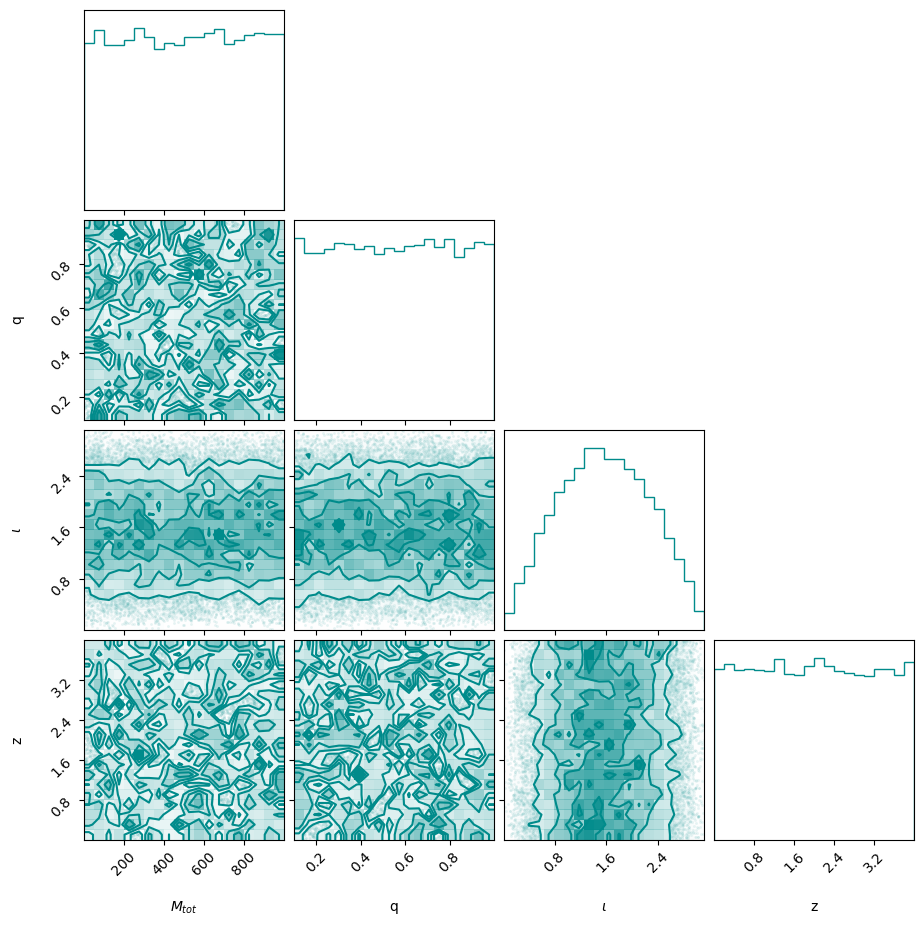

In [26]:
fig_corner = corner.corner(np.array([M_tot, q, iota, z]).T, labels=["$M_{tot}$", "q", "$\iota$", "z"], color="darkcyan")

In [27]:
train_X, test_X, train_y, test_y, train_snr, test_snr = train_test_split(data, det, snr, train_size=0.75)

I fit the scaler on the train dataset only, then transform both train and test. This is done to prevent "information" from the test set to influence the fitting of the classifiers on the scaled train set (through the scaling): the test set must be completely unknown data

In [29]:
#Scale the data first

scaler = StandardScaler()
scaler.fit(train_X)
train_X_s = scaler.transform(train_X)
test_X_s = scaler.transform(test_X)

## Standard classifiers on $det$

In [31]:
def ComputeStats(train_X, train_y, test_X, test_y, clf, plot=False):
    clf.fit(train_X, train_y)

    fpr_train, tpr_train = [], []
    fpr_test, tpr_test = [], []

    for i in [(train_X, train_y, "Train set"), (test_X, test_y, "Test_set")]:
        X, y = i[0], i[1]

        pred = clf.predict(X)
        prob = clf.predict_proba(X)[:, 1]
               
        fpr, tpr, th = roc_curve(y, prob)
        comp, cont = completeness_contamination(pred, y)
        pre = precision_score(y, pred)
        acc = accuracy_score(y, pred)
        auc = roc_auc_score(y, prob)

        print(i[2] + ":")
        print("Completness = " + str(comp))
        print("Contamination = " + str(cont))
        print("Precision = " + str(pre))
        print("Accuracy = " + str(acc))
        print("AUC = " + str(auc))

        if i[2] == "Train set":
            fpr_train = fpr
            tpr_train = tpr
            print("\n")

        else:
            fpr_test = fpr
            tpr_test = tpr

        if plot:
            plt.figure()
            plt.plot(fpr, tpr)
            plt.title(i[2] + " ROC curve")
            plt.xlabel("False positive rate")
            plt.ylabel("True positive rate")
            plt.show()

    return fpr_test, tpr_test

### Support vector machine

In [33]:
cv = GridSearchCV(SVC(), {"C": np.arange(0.01, 2, 0.5), "kernel": ["linear", "rbf", "poly"]}, cv=10, n_jobs=-1)
cv.fit(train_X_s, train_y)
C_reg = cv.best_params_["C"]
best_kernel_svc = cv.best_params_["kernel"]
print("Best regularization = " + str(C_reg))
print("Best kernel = " + str(best_kernel_svc))

fpr_svc, tpr_svc = ComputeStats(train_X_s, train_y, test_X_s, test_y, SVC(C=C_reg, kernel=best_kernel_svc, probability=True))

Best regularization = 1.51
Best kernel = rbf
Train set:
Completness = 0.9175977653631285
Contamination = 0.07811038353601497
Precision = 0.921889616463985
Accuracy = 0.9770666666666666
AUC = 0.9954895831703259


Test_set:
Completness = 0.8641975308641975
Contamination = 0.12863070539419086
Precision = 0.8713692946058091
Accuracy = 0.9616
AUC = 0.9917030639213839


### Decision tree

In [35]:
#Decision tree

cv = GridSearchCV(DecisionTreeClassifier(criterion="entropy"), {"max_depth": np.arange(4, 8)}, cv=10, n_jobs=-1)
cv.fit(train_X_s, train_y)
bd = cv.best_params_["max_depth"]
print("Best depth = " + str(bd))

fpr_dtc, tpr_dtc = ComputeStats(train_X_s, train_y, test_X_s, test_y, DecisionTreeClassifier(max_depth=bd, criterion="entropy"))

Best depth = 7
Train set:
Completness = 0.8254189944134078
Contamination = 0.09540816326530613
Precision = 0.9045918367346939
Accuracy = 0.9625333333333334
AUC = 0.9912610968244115


Test_set:
Completness = 0.7914951989026063
Contamination = 0.1375186846038864
Precision = 0.8624813153961136
Accuracy = 0.9512
AUC = 0.9733819079709103


### Bagging classifier

In [37]:
#Bagging classifier

fpr_b, tpr_b = ComputeStats(train_X_s, train_y, test_X_s, test_y, BaggingClassifier(n_estimators=10))

Train set:
Completness = 0.9827746741154563
Contamination = 0.0023629489603024575
Precision = 0.9976370510396976
Accuracy = 0.9972
AUC = 0.9999208870388627


Test_set:
Completness = 0.8120713305898491
Contamination = 0.11377245508982035
Precision = 0.8862275449101796
Accuracy = 0.9574
AUC = 0.9833645355684604


### Random forest classifier

In [39]:
#Random forest classifier

cv = GridSearchCV(RandomForestClassifier(criterion="entropy", n_jobs=-1), {"max_depth": np.arange(7, 10)}, cv=10, n_jobs=-1)
cv.fit(train_X_s, train_y)
bd = cv.best_params_["max_depth"]
print("Best depth = " + str(bd))

fpr_rf, tpr_rf = ComputeStats(train_X_s, train_y, test_X_s, test_y, RandomForestClassifier(max_depth=bd, criterion="entropy", n_jobs=-1))

Best depth = 9
Train set:
Completness = 0.8663873370577281
Contamination = 0.042695473251028807
Precision = 0.9573045267489712
Accuracy = 0.9753333333333334
AUC = 0.9963863778492982


Test_set:
Completness = 0.8024691358024691
Contamination = 0.08018867924528301
Precision = 0.9198113207547169
Accuracy = 0.961
AUC = 0.989110211176342


### Gradient boosting classifier

In [41]:
#Gradient boosting classifier

cv = GridSearchCV(GradientBoostingClassifier(), {"n_estimators": np.arange(100, 250, 50), "learning_rate": np.arange(0.1, 1, 0.3)}, cv=2, n_jobs=-1, verbose=4)
cv.fit(train_X_s, train_y)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.4, 0.7]),
                         'n_estimators': array([100, 150, 200])},
             verbose=4)

In [42]:
bn = cv.best_params_["n_estimators"]
bl = cv.best_params_["learning_rate"]
print("Best number of estimators = " + str(bn))
print("Best learning rate = " + str(bl))

fpr_gb, tpr_gb = ComputeStats(train_X_s, train_y, test_X_s, test_y, GradientBoostingClassifier(n_estimators=bn, learning_rate=bl))

Best number of estimators = 200
Best learning rate = 0.4
Train set:
Completness = 0.9962756052141527
Contamination = 0.0013999066728884741
Precision = 0.9986000933271115
Accuracy = 0.9992666666666666
AUC = 0.999997609223702


Test_set:
Completness = 0.8984910836762688
Contamination = 0.08774373259052924
Precision = 0.9122562674094707
Accuracy = 0.9726
AUC = 0.9945965372745466


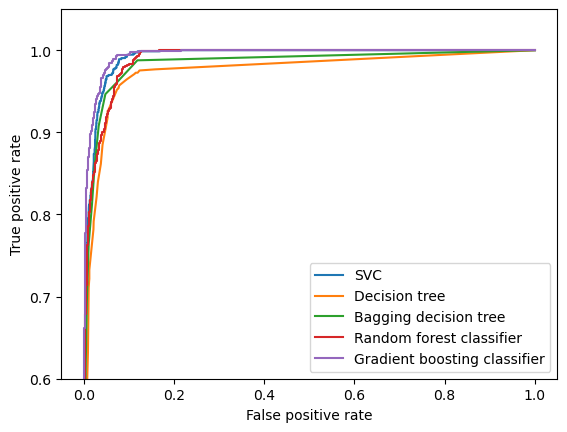

In [43]:
#Plot the ROC curves for each classifier

plt.figure()
plt.plot(fpr_svc, tpr_svc, label="SVC")
plt.plot(fpr_dtc, tpr_dtc, label="Decision tree")
plt.plot(fpr_b, tpr_b, label="Bagging decision tree")
plt.plot(fpr_rf, tpr_rf, label="Random forest classifier")
plt.plot(fpr_gb, tpr_gb, label="Gradient boosting classifier")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.ylim(0.6)
plt.legend()

The gradient boosting classifier seems to be the best classifier overall.

## Gradient boosting best threshold

Completeness = 0.9753086419753086
Contamination = 0.21868131868131868
Precision = 0.7813186813186813
Accuracy = 0.9566
Confusion matrix = 
[[4072   18]
 [ 199  711]]


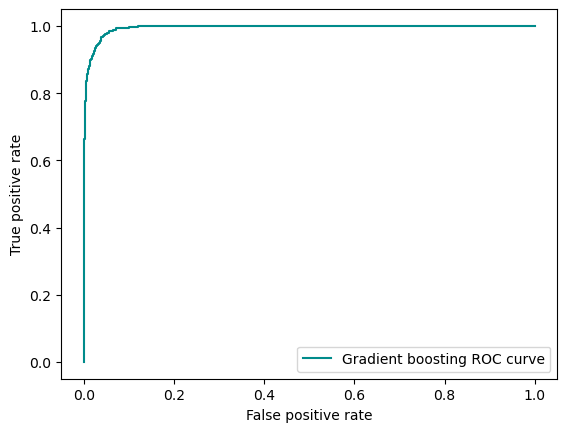

In [46]:
#Gradient boosting classifier
gbc = GradientBoostingClassifier(n_estimators=bn, learning_rate=bl)
gbc.fit(train_X_s, train_y)
prob_gbc = gbc.predict_proba(test_X_s)[:, 1]
fpr_gbc, tpr_gbc, th_gbc = roc_curve(test_y, prob_gbc)

plt.plot(fpr_gbc, tpr_gbc, color="darkcyan", label="Gradient boosting ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()

#Choose the threshold corresponding to the upper left part of the ROC curve
best_th_gbc = th_gbc[np.argmax(tpr_gbc - fpr_gbc)]
best_pred_gbc = np.array(prob_gbc >= best_th_gbc, dtype=int)

#Compute statistics

comp_gbc, cont_gbc = completeness_contamination(best_pred_gbc, test_y)
pre_gbc = precision_score(test_y, best_pred_gbc)
acc_gbc = accuracy_score(test_y, best_pred_gbc)
C_gbc = confusion_matrix(best_pred_gbc, test_y)

print("Completeness = " + str(comp_gbc))
print("Contamination = " + str(cont_gbc))
print("Precision = " + str(pre_gbc))
print("Accuracy = " + str(acc_gbc))
print("Confusion matrix = \n" + str(C_gbc))

## Regression on $snr$

I use a random forest regressor (since it's faster and less memory intensive) to do regression with the $snr$ rather than classification with $det$. The threshold for a detection is $snr > 12$.

In [49]:
cv_rfr = GridSearchCV(RandomForestRegressor(), {"n_estimators": np.arange(200, 300, 50), "max_depth": np.arange(5, 15, 5)}, n_jobs=-1)
cv_rfr.fit(train_X_s, train_snr)
best_n_est = cv_rfr.best_params_["n_estimators"]
best_md = cv_rfr.best_params_["max_depth"]
print("Best number of estimators = " + str(best_n_est))
print("Best max depth = " + str(best_md))

Best number of estimators = 200
Best max depth = 10


In [50]:
rfr = RandomForestRegressor(n_estimators=best_n_est, max_depth=best_md, n_jobs=-1)
rfr.fit(train_X_s, train_snr)
labels_reg = np.array(rfr.predict(test_X_s) > 12, dtype=int)

In [51]:
#Compute statistics

comp_rfr, cont_rfr = completeness_contamination(labels_reg, test_y)
pre_rfr = precision_score(test_y, labels_reg)
acc_rfr = accuracy_score(test_y, labels_reg)
C_rfr = confusion_matrix(labels_reg, test_y)

In [52]:
print("Completeness = " + str(comp_rfr))
print("Contamination = " + str(cont_rfr))
print("Precision = " + str(pre_rfr))
print("Accuracy = " + str(acc_rfr))
print("Confusion matrix = \n" + str(C_rfr))

Completeness = 0.8669410150891632
Contamination = 0.20901126408010012
Precision = 0.7909887359198998
Accuracy = 0.9472
Confusion matrix = 
[[4104   97]
 [ 167  632]]


The random forest regressor has worse completeness than the GBC for this $snr$ threshold, and similar accuracy.

## PCA

In [27]:
pca = PCA()
train_X_red = pca.fit_transform(train_X_s)
test_X_red = pca.transform(test_X_s)

Text(0, 0.5, 'Component 1')

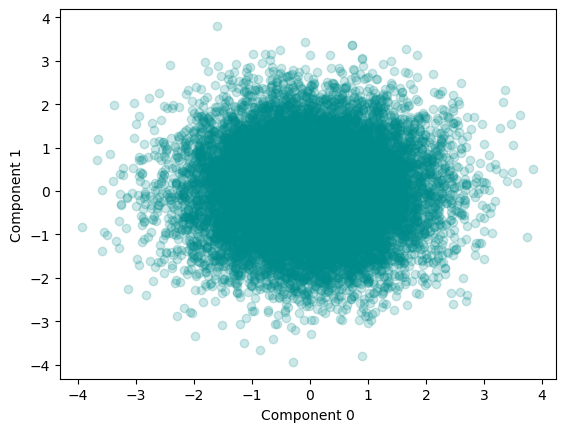

In [28]:
n_comp = pca.n_components_
evecs = pca.components_

plt.figure()
plt.scatter(train_X_red[:, 0], train_X_red[:, 1], color="darkcyan", alpha=0.2)
plt.xlabel("Component 0")
plt.ylabel("Component 1")

Seems like PCA can't really separate the components very well.

Text(0, 0.5, 'Feature importance')

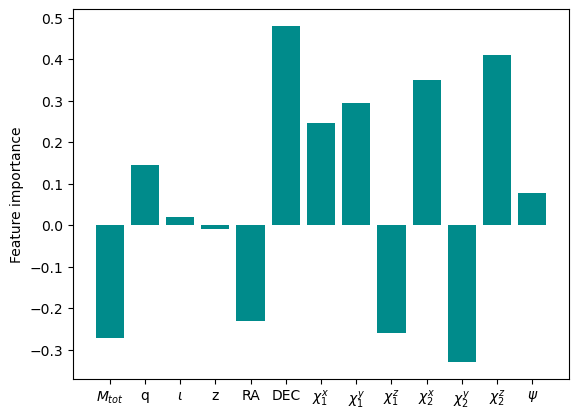

In [30]:
plt.figure()
plt.bar(names, evecs[0], color="darkcyan")
plt.ylabel("Feature importance")

Text(0, 0.5, 'Cumulative explained variance')

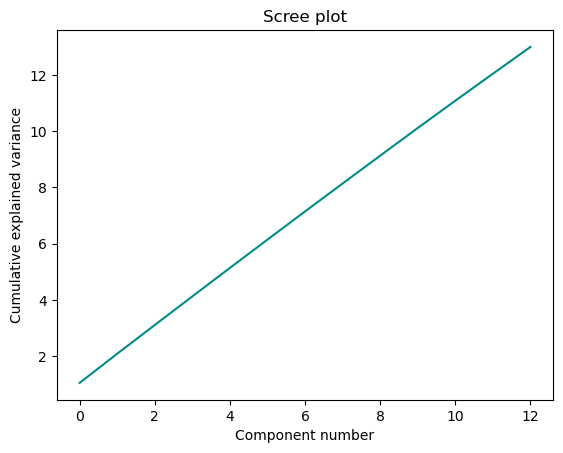

In [31]:
exp_var = np.cumsum(pca.explained_variance_)

plt.figure()
plt.plot(np.arange(0, n_comp), exp_var, color="darkcyan")
plt.title("Scree plot")
plt.xlabel("Component number")
plt.ylabel("Cumulative explained variance")

## Locally Linear Embedding

In [33]:
lle = LocallyLinearEmbedding(n_components=2, n_jobs=-1)
train_X_lle = lle.fit_transform(train_X_s)
test_X_lle = lle.transform(test_X_s)

Text(0, 0.5, 'Component 1')

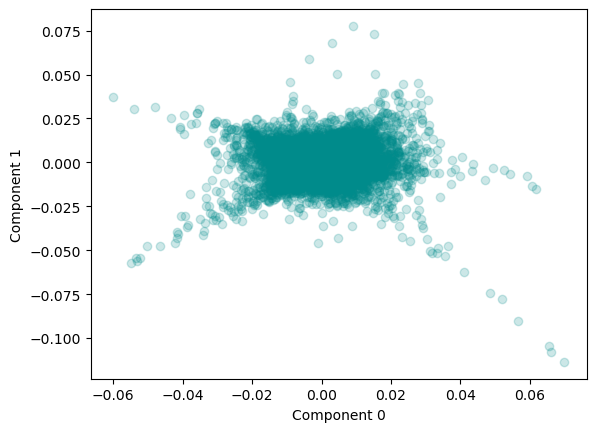

In [34]:
plt.figure()
plt.scatter(train_X_lle[:, 0], train_X_lle[:, 1], color="darkcyan", alpha=0.2)
plt.xlabel("Component 0")
plt.ylabel("Component 1")

In this case LLE is not much better than PCA to separate well all the components.

## Gradient boosting on PCA

In [37]:
cv_pca = GridSearchCV(GradientBoostingClassifier(), {"n_estimators": np.arange(100, 250, 50), "learning_rate": np.arange(0.1, 1, 0.3)}, cv=2, n_jobs=-1, verbose=4)
cv_pca.fit(train_X_red, train_y)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.4, 0.7]),
                         'n_estimators': array([100, 150, 200])},
             verbose=4)

Best number of estimators = 200
Best learning rate = 0.4
Completeness = 0.9445945945945946
Contamination = 0.3651226158038147
Precision = 0.6348773841961853
Accuracy = 0.9114
Confusion matrix = 
[[3858   41]
 [ 402  699]]


Text(0, 0.5, 'True positive rate')

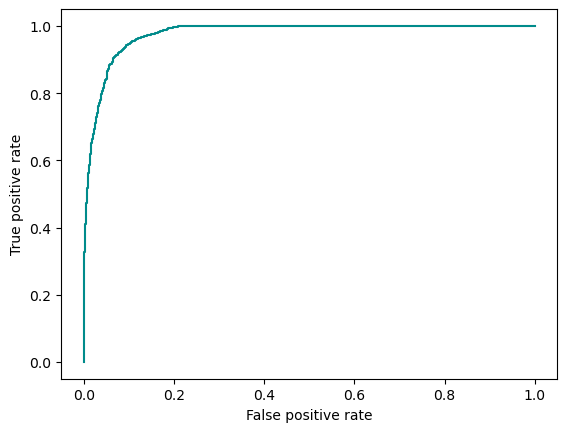

In [38]:
#Gradient boosting classifier

bn = cv_pca.best_params_["n_estimators"]
bl = cv_pca.best_params_["learning_rate"]
print("Best number of estimators = " + str(bn))
print("Best learning rate = " + str(bl))

gbc_pca = GradientBoostingClassifier(n_estimators=bn, learning_rate=bl)
gbc_pca.fit(train_X_red, train_y)
prob = gbc_pca.predict_proba(test_X_red)[:, 1]
fpr, tpr, th = roc_curve(test_y, prob)

#Choose the threshold corresponding to the upper left part of the ROC curve
best_th = th[np.argmax(tpr - fpr)]
best_pred = np.array(prob >= best_th, dtype=bool)

#Compute statistics

comp, cont = completeness_contamination(best_pred, test_y)
pre = precision_score(test_y, best_pred)
acc = accuracy_score(test_y, best_pred)
C = confusion_matrix(best_pred, test_y)

print("Completeness = " + str(comp))
print("Contamination = " + str(cont))
print("Precision = " + str(pre))
print("Accuracy = " + str(acc))
print("Confusion matrix = \n" + str(C))

#ROC curve

plt.figure()
plt.plot(fpr, tpr, color="darkcyan")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

## Gradient boosting on LLE

In [40]:
cv_lle = GridSearchCV(GradientBoostingClassifier(), {"n_estimators": np.arange(100, 250, 50), "learning_rate": np.arange(0.1, 1, 0.3)}, cv=5, n_jobs=-1, verbose=4)
cv_lle.fit(train_X_lle, train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.4, 0.7]),
                         'n_estimators': array([100, 150, 200])},
             verbose=4)

Best number of estimators = 100
Best learning rate = 0.1
Completeness = 0.8851351351351351
Contamination = 0.6512247071352503
Precision = 0.34877529286474973
Accuracy = 0.7384
Confusion matrix = 
[[3037   85]
 [1223  655]]


Text(0, 0.5, 'True positive rate')

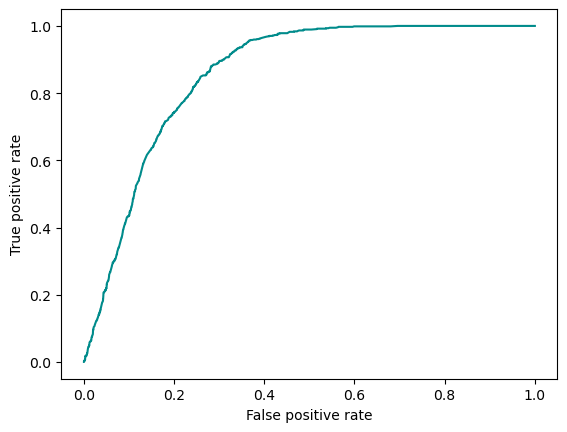

In [41]:
#Gradient boosting classifier

bn = cv_lle.best_params_["n_estimators"]
bl = cv_lle.best_params_["learning_rate"]
print("Best number of estimators = " + str(bn))
print("Best learning rate = " + str(bl))

gbc_lle = GradientBoostingClassifier(n_estimators=bn, learning_rate=bl)
gbc_lle.fit(train_X_lle, train_y)
prob = gbc_lle.predict_proba(test_X_lle)[:, 1]
fpr, tpr, th = roc_curve(test_y, prob)

#Choose the threshold corresponding to the upper left part of the ROC curve
best_th = th[np.argmax(tpr - fpr)]
best_pred = np.array(prob >= best_th, dtype=bool)

#Compute statistics

comp, cont = completeness_contamination(best_pred, test_y)
pre = precision_score(test_y, best_pred)
acc = accuracy_score(test_y, best_pred)
C = confusion_matrix(best_pred, test_y)

print("Completeness = " + str(comp))
print("Contamination = " + str(cont))
print("Precision = " + str(pre))
print("Accuracy = " + str(acc))
print("Confusion matrix = \n" + str(C))

#ROC curve

plt.figure()
plt.plot(fpr, tpr, color="darkcyan")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

The GBC has performed worse than on the original dataset on both PCA and LLE.

## Neural network

In [44]:
#Split the original test set into validation and test set for the NN

val_X_nn, test_X_nn, val_y_nn, test_y_nn = train_test_split(test_X_s, test_y, train_size=0.5)

In [45]:
HP_NUM_UNITS = hp.HParam("num_units", hp.Discrete([30, 50, 100]))
HP_DROPOUT = hp.HParam("dropout", hp.Discrete([0.2, 0.5, 0.8]))

METRIC_ACCURACY = "accuracy"
METRIC_RECALL = "recall"

with tf.summary.create_file_writer("logs/hparam_tuning_GW").as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name="Accuracy"), hp.Metric(METRIC_RECALL, display_name="Recall")],
  )

In [46]:
#Define the model

def train_test_model(hparams):
    model = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=train_X_s.shape[-1]),
        keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu"),
        keras.layers.Dropout(hparams[HP_DROPOUT]),
        keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu"),
        keras.layers.Dropout(hparams[HP_DROPOUT]),
        keras.layers.Dense(units=1, activation="sigmoid")
    ])
    
    model.compile(loss=keras.losses.BinaryCrossentropy(), 
                  optimizer="adam", 
                  metrics=[keras.metrics.BinaryAccuracy(name="binary accuracy"), keras.metrics.Recall(name="recall")])
    
    fit = model.fit(train_X_s, train_y, epochs=3, validation_data=(val_X_nn, val_y_nn), use_multiprocessing=True)

    _, accuracy, recall = model.evaluate(test_X_nn, test_y_nn)
    
    return accuracy, recall

In [47]:
#Define the run function

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # Record the values used in this trial
      
    accuracy, recall = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
    tf.summary.scalar(METRIC_RECALL, recall, step=1)

In [48]:
keras.backend.clear_session()

In [49]:
#Run the sessions to tune the hyperparameters

session_num = 0

for dropout_rate in HP_DROPOUT.domain.values:
    for num_units in HP_NUM_UNITS.domain.values:
        hparams = {HP_NUM_UNITS: num_units,
                  HP_DROPOUT: dropout_rate
                  }
        
        run_name = "run_" + str(session_num)
        print('--- Starting trial: ' + str(run_name))
        print({h.name: hparams[h] for h in hparams})
    
        run('logs/hparam_tuning_GW/' + run_name, hparams)
        session_num += 1

--- Starting trial: run_0
{'num_units': 30, 'dropout': 0.2}
Epoch 1/3
469/469 [==============================] - 4s 3ms/step - loss: 0.3118 - binary accuracy: 0.8655 - recall: 0.2377 - val_loss: 0.2027 - val_binary accuracy: 0.9080 - val_recall: 0.5691
Epoch 2/3
469/469 [==============================] - 1s 2ms/step - loss: 0.1925 - binary accuracy: 0.9088 - recall: 0.6327 - val_loss: 0.1616 - val_binary accuracy: 0.9300 - val_recall: 0.7263
Epoch 3/3
79/79 [==============================] - 0s 1ms/step - loss: 0.1364 - binary accuracy: 0.9412 - recall: 0.7790
--- Starting trial: run_1
{'num_units': 50, 'dropout': 0.2}
Epoch 1/3
469/469 [==============================] - 2s 3ms/step - loss: 0.2719 - binary accuracy: 0.8803 - recall: 0.3856 - val_loss: 0.1740 - val_binary accuracy: 0.9192 - val_recall: 0.7046
Epoch 2/3
469/469 [==============================] - 1s 2ms/step - loss: 0.1660 - binary accuracy: 0.9236 - recall: 0.7216 - val_loss: 0.1452 - val_binary accuracy: 0.9372 - val_re

In [50]:
%tensorboard --logdir logs/hparam_tuning_GW

In [95]:
#Best accuracy model

# best_num_units = 100
# best_dropout = 0.2

#Best recall model

best_num_units = 100
best_dropout = 0.2

In [96]:
keras.backend.clear_session()

In [97]:
model_nn = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=train_X_s.shape[-1]),
    keras.layers.Dense(best_num_units, activation="relu"),
    keras.layers.Dropout(best_dropout),
    keras.layers.Dense(best_num_units, activation="relu"),
    keras.layers.Dropout(best_dropout),
    keras.layers.Dense(units=1, activation="sigmoid")
])

model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1400      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,601
Trainable params: 11,601
Non-trainable params: 0
_________________________________________________________________


In [98]:
model_nn.compile(loss=keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
model_nn.fit(train_X_s, train_y, epochs=20, validation_data=(val_X_nn, val_y_nn), use_multiprocessing=True)

Epoch 1/20
469/469 [==============================] - 3s 3ms/step - loss: 0.2182 - binary_accuracy: 0.9047 - recall: 0.5442 - val_loss: 0.1383 - val_binary_accuracy: 0.9396 - val_recall: 0.7940
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.1402 - binary_accuracy: 0.9370 - recall: 0.7819 - val_loss: 0.1220 - val_binary_accuracy: 0.9496 - val_recall: 0.8401
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1199 - binary_accuracy: 0.9467 - recall: 0.8241 - val_loss: 0.1187 - val_binary_accuracy: 0.9432 - val_recall: 0.7534
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.1109 - binary_accuracy: 0.9511 - recall: 0.8376 - val_loss: 0.1067 - val_binary_accuracy: 0.9496 - val_recall: 0.8699
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.1054 - binary_accuracy: 0.9543 - recall: 0.8489 - val_loss: 0.0995 - val_binary_accuracy: 0.9520 - val_recall: 0.8672
Epoch 6/20
469/469 [==========

79/79 [==============================] - 0s 1ms/step
Neural network:
Completeness = 0.9757412398921833
Contamination = 0.2657200811359026


GBC:
Completeness = 0.972972972972973
Contamination = 0.232409381663113


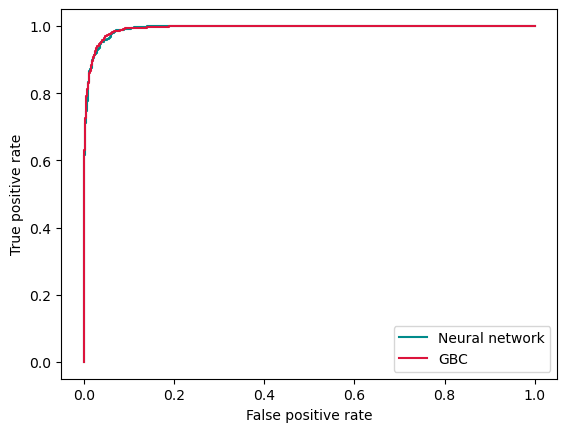

In [99]:
nn_prob = model_nn.predict(test_X_nn)

fpr_nn, tpr_nn, th_nn = roc_curve(test_y_nn, nn_prob)
best_th_nn = th_nn[np.argmax(tpr_nn - fpr_nn)]
nn_pred = np.array(nn_prob.flatten() > best_th_nn, dtype=int)

comp_nn, cont_nn = completeness_contamination(nn_pred, test_y_nn)

print("Neural network:")
print("Completeness = " + str(comp_nn))
print("Contamination = " + str(cont_nn))
print("\n")
print("GBC:")
print("Completeness = " + str(comp_gbc))
print("Contamination = " + str(cont_gbc))

plt.figure()
plt.plot(fpr_nn, tpr_nn, color="darkcyan", label="Neural network")
plt.plot(fpr_gbc, tpr_gbc, color="crimson", label="GBC")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()

The performance between NN and GBC is similar, at least for a simple NN like the one used.